<a href="https://colab.research.google.com/github/fabriciocovalesci/tcc_predict_crypto/blob/main/model_predict/predict_crypto/polygon/Polygon_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modelo preditivo Polygon

- Instalar biblioteca **yfinance**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- Importar bibliotecas de manipulação de dados

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

- Importar bibliotecas realizar as predições

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

- Importar bibliotecas para plotar gráficos

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

- Importar bibliotecas internas do python

In [ ]:
from functools import reduce
from datetime import datetime
from math import sqrt

- Definir datas para capturar os dados

In [ ]:
date_today = datetime.strftime(datetime.today(), '%Y-%m-%d')
date_init = "2014-01-01"

- Criar funções auxiliares 

In [ ]:
TICKER = "MATIC-USD"

def download_tickers(ticker):
  try:
    asset = yf.download(ticker, start=date_init, end=date_today, interval='1d')
    return asset.Close
  except Exception as err:
    print(f"ERROR: {err}")

  
def create_data_frame(asset_close, ticker):
  return pd.DataFrame(asset_close).rename(columns = {'Close': ticker})


def mean_absolute_percentage_error(y_true, y_pred):
	"""Take in true and predicted values and calculate the MAPE score"""
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Download dos dados

In [ ]:
df_matic = yf.download(TICKER, date_init, date_today)
df_matic = df_matic.reset_index()

[*********************100%***********************]  1 of 1 completed


- Renomendo colunas

In [ ]:
df_matic.rename({'Date': 'timestamp', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Adj Close': 'close', 'Volume': 'volume' }, axis=1, inplace=True)

In [ ]:
df_matic.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
Close               float64
close               float64
volume                int64
dtype: object

- Converter data

In [ ]:
df_matic['timestamp'] = pd.to_datetime(df_matic['timestamp'], format="%Y-%m-%d")

- Criar médias móveis de 7 dias e 21 dias

In [ ]:
df_matic['mm7d'] = df_matic['close'].rolling(7).mean()
df_matic['mm21d'] = df_matic['close'].rolling(21).mean()

df_matic.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1275,2022-10-24,0.899789,0.906729,0.874775,0.893877,0.893877,516315604,0.854129,0.826951
1276,2022-10-25,0.893820,0.942262,0.876954,0.919739,0.919739,535291216,0.862019,0.830932
1277,2022-10-26,0.919462,0.964176,0.919105,0.938138,0.938138,571732025,0.875169,0.835065
1278,2022-10-27,0.938126,0.946050,0.899352,0.904834,0.904834,521052785,0.888700,0.838483
1279,2022-10-28,0.904850,0.945018,0.898134,0.944848,0.944848,409318237,0.904808,0.843861


- Função de agrupamento dos dados

In [ ]:
def group_data(type_group):
  new_df = df_matic.groupby(pd.Grouper(key="timestamp", freq=type_group)).sum()
  new_df.reset_index(inplace=True)
  return new_df

- Função para plotar grafico conforme o Agrupamento dos Dados
- Tipo de agrupamento:
- Por Meses (M) ou por Semanas (W)
- Por Ano (year)
- Tipo de grafico: 'bar',  'line',  'hist',  'barh'

In [ ]:
def create_plot_custom(filter_Mounth_or_Week, year, type_plot):
  """ 
    Cria um grafico filtrando por Ano, Meses ou Semanas

    filter_Mounth_or_Week: 'M' ou 'W'
    type_plot: 'line', 'bar', 'hist', 'barh'
  
  """
  if year >= 2014 and year <= 2022 and filter_Mounth_or_Week in ("M", "W"):
    filtro_label = None
    df_filter = group_data(filter_Mounth_or_Week)
    include = df_filter[df_filter['timestamp'].dt.year == year]
    meses = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    if len(include.index) <= 12:
      include.index = meses[:len(include.index)]
      filtro_label = "Meses"
    elif len(include.index) > 50:
      include.index = [i for i in range(0, len(include.index))]
      filtro_label = "Semanas"
    include.plot(y="close", kind=type_plot, figsize=(14, 8),rot=30, title=f'Distruibuição por {filtro_label} - ano {year}', ylabel='Preço US$', xlabel=filtro_label, color="blue")

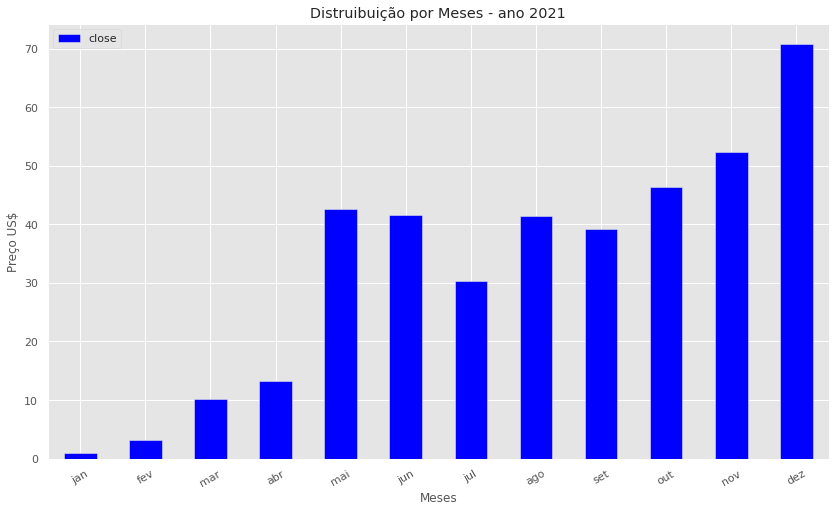

In [ ]:
create_plot_custom("M", 2021, "bar")

- Empurrando para frente os valores da criptomoeda

In [ ]:
df_matic['close'] = df_matic['close'].shift(-1)
df_matic.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1275,2022-10-24,0.899789,0.906729,0.874775,0.893877,0.919739,516315604,0.854129,0.826951
1276,2022-10-25,0.893820,0.942262,0.876954,0.919739,0.938138,535291216,0.862019,0.830932
1277,2022-10-26,0.919462,0.964176,0.919105,0.938138,0.904834,571732025,0.875169,0.835065
1278,2022-10-27,0.938126,0.946050,0.899352,0.904834,0.944848,521052785,0.888700,0.838483
1279,2022-10-28,0.904850,0.945018,0.898134,0.944848,NaN,409318237,0.904808,0.843861


- Remover os dados nulos

In [ ]:
df_matic.dropna(inplace=True)
df_matic

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
20,2019-05-18,0.014353,0.014799,0.012092,0.012293,0.020231,56628223,0.009823,0.005889
21,2019-05-19,0.012320,0.020749,0.012309,0.020231,0.029343,141440073,0.011960,0.006642
22,2019-05-20,0.020231,0.032911,0.019292,0.029343,0.029454,396597433,0.014913,0.007874
23,2019-05-21,0.029349,0.045017,0.025149,0.029454,0.022186,698132268,0.018014,0.009064
24,2019-05-22,0.029454,0.031612,0.020417,0.022186,0.027273,266364855,0.019824,0.009912
...,...,...,...,...,...,...,...,...,...
1274,2022-10-23,0.832370,0.901422,0.822506,0.899837,0.893877,370198046,0.847469,0.822567
1275,2022-10-24,0.899789,0.906729,0.874775,0.893877,0.919739,516315604,0.854129,0.826951
1276,2022-10-25,0.893820,0.942262,0.876954,0.919739,0.938138,535291216,0.862019,0.830932
1277,2022-10-26,0.919462,0.964176,0.919105,0.938138,0.904834,571732025,0.875169,0.835065


- Testar se o DataFrame possui dados nulos

In [ ]:
assert df_matic.isnull().sum().sum() == 0

- Separar os dados em Treino, Teste e Validação. 

In [ ]:
qtd_linhas = len(df_matic)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:881 linhas teste= 881:1258 linhas validação= 1258'

- Separar a **labels** que será o target a ser encontrado pelo modelo preditivo
- Separar as **features** que serão utilizadas para prever o valor final

In [ ]:
features = df_matic.drop(['timestamp', 'close'], 1)
labels = df_matic['close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


- Escolhendo as melhores features com Kbest

In [ ]:
features_list = ('timestamp', 'open', 'high', 'low', 'volume', 'mm7d', 'mm21d')

selector = SelectKBest(score_func=f_regression, k='all').fit(features, labels)
x_new = selector.transform(features)
scores = selector.scores_

raw_pairs = zip(features_list[1:], scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print("Melhores features:")
print(k_best_features_final)

Melhores features:
{'volume': 122328.569082807, 'high': 87412.18724535321, 'low': 73921.04555732108, 'open': 68744.83629793064, 'mm21d': 54528.36798914061, 'mm7d': 1308.3668307804269}


- Separando as features escolhidas, com melhor pontuação

In [ ]:
features = df_matic.loc[:,['volume','high', 'low', 'open', 'mm21d']]
features

,volume,high,low,open,mm21d
20,56628223,0.014799,0.012092,0.014353,0.005889
21,141440073,0.020749,0.012309,0.012320,0.006642
22,396597433,0.032911,0.019292,0.020231,0.007874
23,698132268,0.045017,0.025149,0.029349,0.009064
24,266364855,0.031612,0.020417,0.029454,0.009912
...,...,...,...,...,...
1274,370198046,0.901422,0.822506,0.832370,0.822567
1275,516315604,0.906729,0.874775,0.899789,0.826951
1276,535291216,0.942262,0.876954,0.893820,0.830932
1277,571732025,0.964176,0.919105,0.919462,0.835065


- Criando Pipeline

In [ ]:
pipeline_linear_regression = make_pipeline(MinMaxScaler(), LinearRegression())

- Separa os dados de treino teste e validação

In [ ]:
X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

881 881
377 377


- Treina modelo

In [ ]:
pipeline_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

- Conferir a pontuação do modelo

In [ ]:
score_model = pipeline_linear_regression.score(X_test, y_test)
f'Teste pontuação para avaliar a consistência do modelo: {score_model * 100:.2f}%'

'Teste pontuação para avaliar a consistência do modelo: 97.30%'

- Pega último dado do dataframe

In [ ]:
data_pred = ['volume','high', 'low', 'open', 'mm21d']
df_matic.tail(1)

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1278,2022-10-27,0.938126,0.94605,0.899352,0.904834,0.944848,521052785,0.8887,0.838483


- Testar a predição

In [ ]:
y_predicted = pipeline_linear_regression.predict(df_matic.tail(1)[data_pred])
y_predicted

array([0.90972457])

In [ ]:
rmse = sqrt(mean_squared_error(df_matic.tail(1)["close"], y_predicted))
rmse

0.03512343122885064

- Realizar a predição com os dados de testes(dados que o modelo desconhece)

In [ ]:
previsao = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

data_btc_full=df_matic["timestamp"]
data_btc = data_btc_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

res_full = df_matic["close"]
res = res_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]


predict2 = pipeline_linear_regression.predict(previsao)


df = pd.DataFrame({ "data_polygon": data_btc, "real": res , "previsao": predict2 })

df["real"] = df["real"].shift(+1)

df.set_index("data_polygon", inplace= True)

df.tail()



,real,previsao
data_polygon,,
2022-10-22,0.832385,0.815777
2022-10-23,0.899837,0.838338
2022-10-24,0.893877,0.884759
2022-10-25,0.919739,0.893322
2022-10-26,0.938138,0.929437


- Plotar os resultados

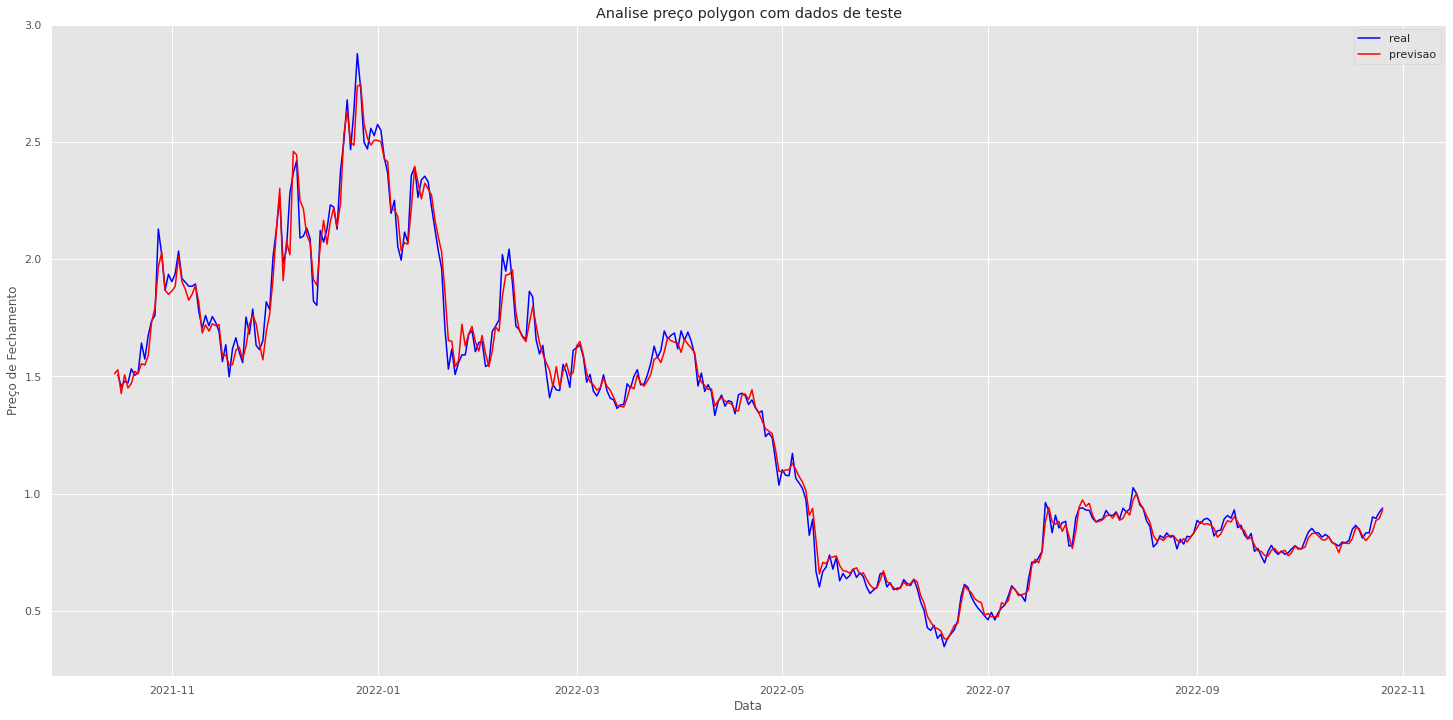

In [ ]:
plt.figure(figsize=(25,12))
plt.title("Analise preço polygon com dados de teste")
plt.plot(df["real"], label="real", color="blue")
plt.plot(df["previsao"], label="previsao", color="red")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
leg = plt.legend()

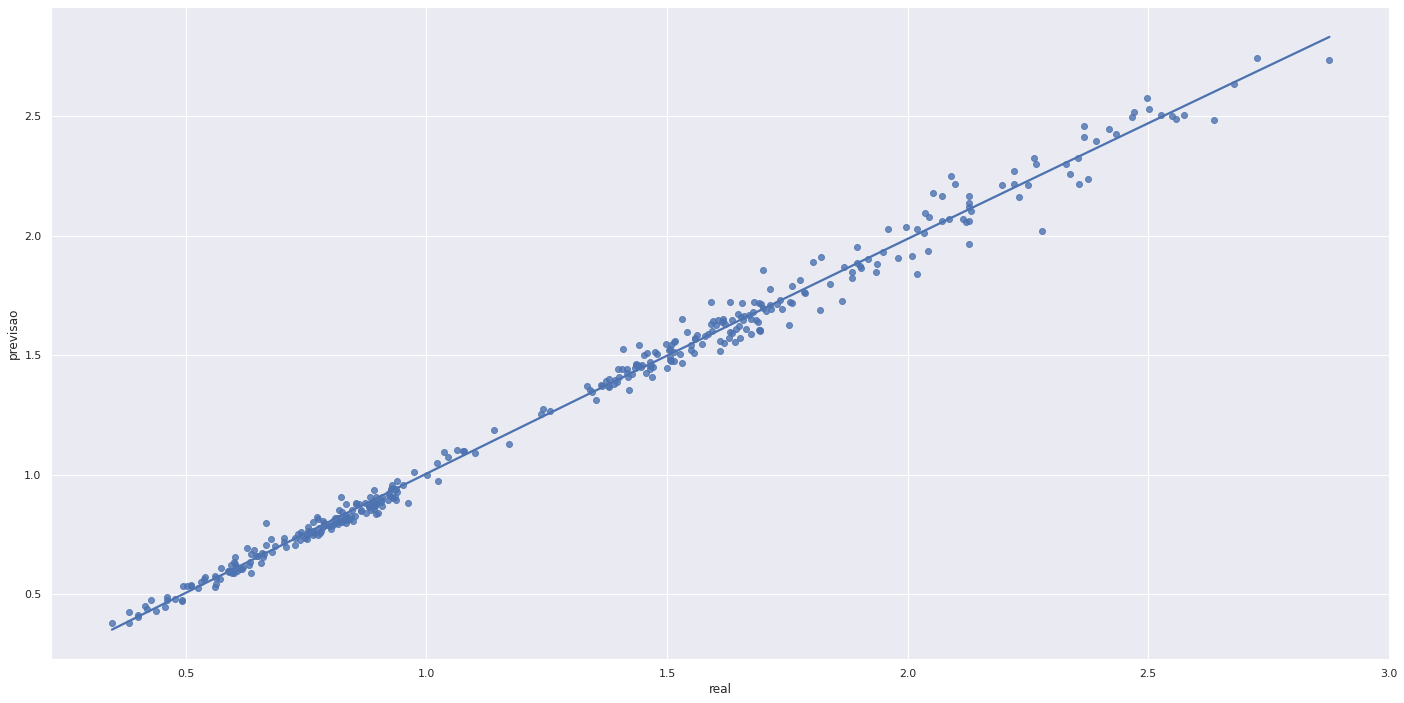

In [ ]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(24, 12)})
sns.regplot(x ="real", y ="previsao", data = df, ci=False, order=2)

- Export modelo preditivo 

In [ ]:
joblib.dump(pipeline_linear_regression, 'model_matic_usd.pkl')

['model_matic_usd.pkl']

- Import modelo preditivo

In [ ]:
model = joblib.load('model_matic_usd.pkl')